
DETECTED METRICS
Numeric columns: ['n_tokens', 'latency', 'input_tokens', 'output_tokens', 'cost_usd']
Total records: 40

Data preview:
                       model approach  n_tokens   latency  cost_usd
0  claude-haiku-4-5-20251001      clm      1036  2.431795  0.001469
1  claude-haiku-4-5-20251001      clm       988  1.943179  0.001430
2  claude-haiku-4-5-20251001      clm       948  2.043530  0.001398
3  claude-haiku-4-5-20251001      clm       992  2.392951  0.001434
4  claude-haiku-4-5-20251001      clm       996  2.804038  0.001437

CLM vs NL PERFORMANCE SUMMARY
                       model  n_tokens_nl  n_tokens_clm  n_tokens_gain_%  \
0  claude-haiku-4-5-20251001       3076.0         995.5            67.64   
1   claude-opus-4-1-20250805       2919.5         995.5            65.90   

   latency_nl  latency_clm  latency_gain_%  cost_usd_nl  cost_usd_clm  
0      6.0521       2.1864           63.87       0.0038        0.0014  
1      9.7943       5.8047           40.73       0.

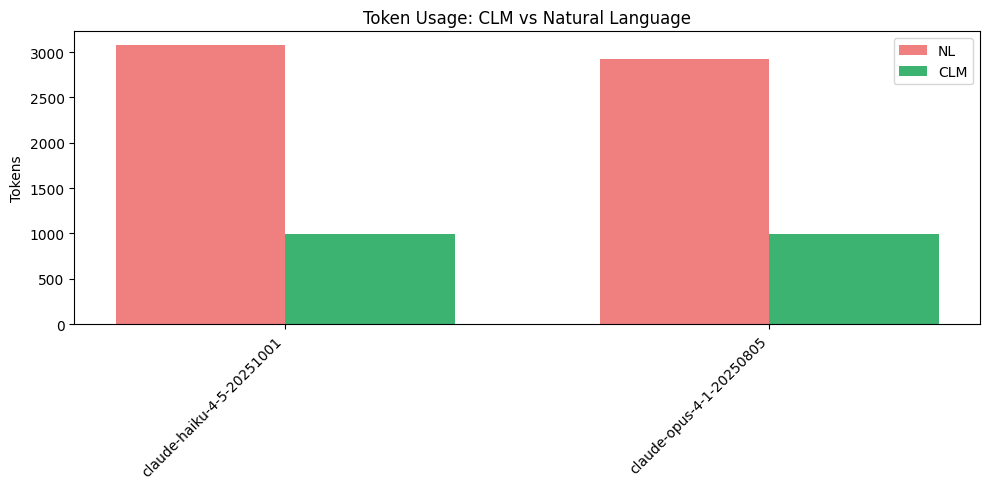

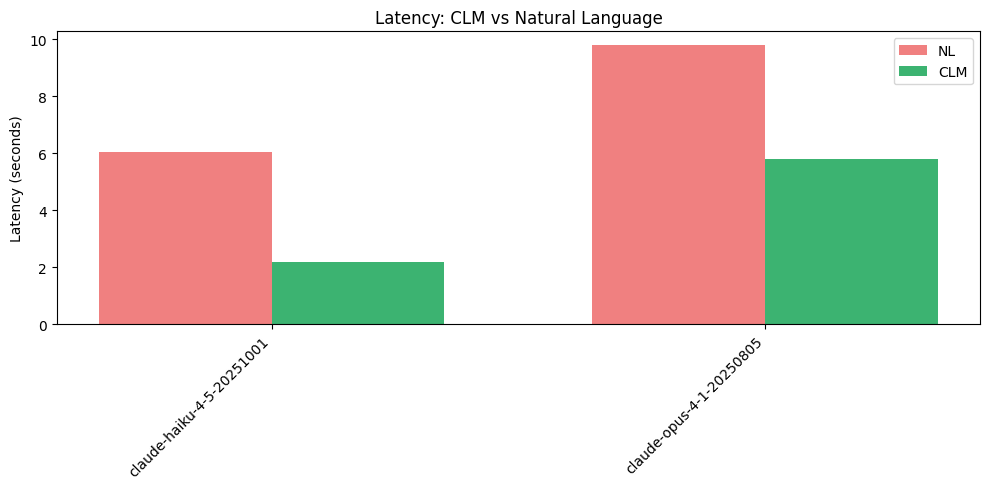

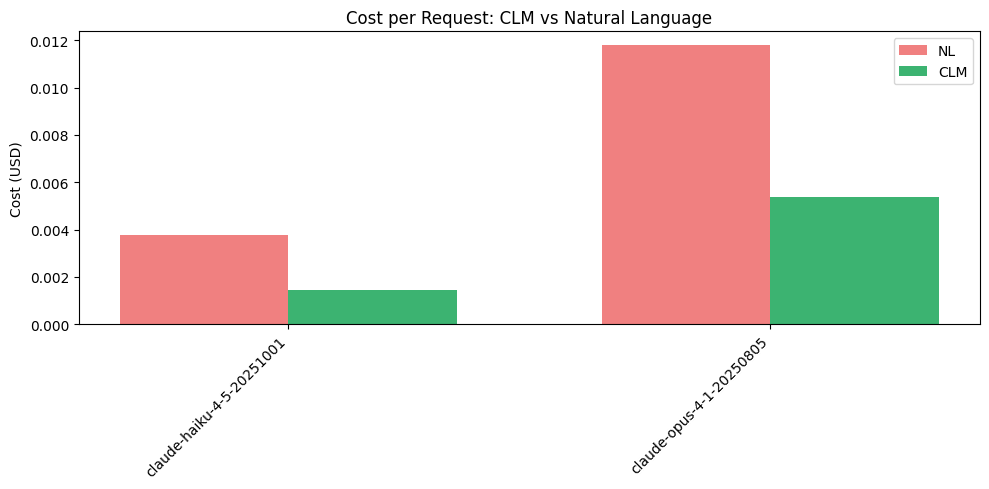


SUMMARY TOTALS
Average per-user monthly savings:     $0.0000
Total monthly savings (30,000 users): $-47,634.90
Projected annual savings:             $-571,618.78

Performance Improvements:
  Token reduction:   66.8%
  Latency reduction: 52.3%

✅ Results exported to 'clm_vs_nl_full_summary.csv'
✅ Benchmark analysis complete.


In [23]:
"""
CLM vs Natural Language (NL) Benchmark Analyzer - FIXED FOR YOUR DATA
----------------------------------------------------------------------
Calculates costs from token counts using model pricing
"""

import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# === Configuration ===
BENCHMARK_FILE = Path("clm_vs_nl.json")
USER_COUNT = 30_000
TOKENS_PER_USER_PER_MONTH = 1_000_000

# === Model Pricing (per 1M tokens) ===
MODEL_PRICING = {
    "claude-sonnet-4-5": {"input": 3.00, "output": 15.00},
    "claude-haiku-3.5": {"input": 0.80, "output": 4.00},
    "claude-haiku-4-5-20251001": {"input": 0.80, "output": 4.00},  # Haiku pricing
    "claude-opus-4.1": {"input": 15.00, "output": 75.00},
}

# === Load data ===
with open(BENCHMARK_FILE, "r") as f:
    raw_data = json.load(f)

data = {k: v for k, v in raw_data.items() if v.get("clm") or v.get("nl")}

records = []
for model, results in data.items():
    for approach, samples in results.items():
        for s in samples:
            if isinstance(s, dict):
                s = {k.lower(): v for k, v in s.items()}
                
                # ✅ CALCULATE COST from tokens
                input_tokens = s.get('input_tokens', 0)
                output_tokens = s.get('output_tokens', 0)
                
                # Get pricing for this model
                pricing = MODEL_PRICING.get(model, {"input": 3.0, "output": 15.0})
                
                # Calculate cost in USD
                cost_usd = (
                    (input_tokens * pricing['input'] / 1_000_000) +
                    (output_tokens * pricing['output'] / 1_000_000)
                )
                
                s['cost_usd'] = cost_usd
                s.update({"model": model, "approach": approach})
                records.append(s)

if not records:
    raise ValueError("No valid benchmark entries found in file.")

df = pd.DataFrame(records)

# === Detect numeric metrics ===
numeric_cols = df.select_dtypes(include="number").columns.tolist()
print(f"\n{'='*70}")
print("DETECTED METRICS")
print('='*70)
print(f"Numeric columns: {numeric_cols}")
print(f"Total records: {len(df)}")
print(f"\nData preview:")
print(df[['model', 'approach', 'n_tokens', 'latency', 'cost_usd']].head())

# === Compute per-model averages ===
summary = (
    df.groupby(["model", "approach"])[numeric_cols]
    .mean()
    .reset_index()
    .pivot(index="model", columns="approach")
)
summary.columns = [f"{a}_{b}" for a, b in summary.columns]
summary.reset_index(inplace=True)

# === Relative improvements ===
def pct_diff(nl, clm):
    try:
        if nl == 0:
            return 0
        return round((nl - clm) / nl * 100, 2)
    except Exception:
        return 0

for metric in numeric_cols:
    nl_col, clm_col = f"{metric}_nl", f"{metric}_clm"
    if nl_col in summary.columns and clm_col in summary.columns:
        summary[f"{metric}_gain_%"] = summary.apply(
            lambda x: pct_diff(x.get(nl_col, 0), x.get(clm_col, 0)), axis=1
        )

# === Calculate monthly costs per user ===
summary["nl_cost_per_request"] = summary.get("cost_usd_nl", 0)
summary["clm_cost_per_request"] = summary.get("cost_usd_clm", 0)

# Estimate costs for 1M tokens/month per user
# Assuming average request uses the tokens we saw
avg_tokens_per_request_nl = summary.get("n_tokens_nl", 1000)
avg_tokens_per_request_clm = summary.get("n_tokens_clm", 1000)

requests_per_month_nl = TOKENS_PER_USER_PER_MONTH / avg_tokens_per_request_nl
requests_per_month_clm = TOKENS_PER_USER_PER_MONTH / avg_tokens_per_request_clm

summary["nl_monthly_cost_per_user"] = (summary["nl_cost_per_request"] * requests_per_month_nl).fillna(0)
summary["clm_monthly_cost_per_user"] = (summary["clm_cost_per_request"] * requests_per_month_clm).fillna(0)

# === Savings Calculations ===
summary["user_monthly_savings"] = (
    summary["nl_monthly_cost_per_user"] - summary["clm_monthly_cost_per_user"]
).fillna(0)

summary["global_monthly_savings_usd"] = (
    summary["user_monthly_savings"] * USER_COUNT
)

summary["annual_global_savings_usd"] = (
    summary["global_monthly_savings_usd"] * 12
)

# === Display results ===
print(f"\n{'='*70}")
print("CLM vs NL PERFORMANCE SUMMARY")
print('='*70)

display_cols = [
    "model",
    "n_tokens_nl",
    "n_tokens_clm",
    "n_tokens_gain_%",
    "latency_nl",
    "latency_clm",
    "latency_gain_%",
    "cost_usd_nl",
    "cost_usd_clm",
]

# Filter columns that exist
display_cols = [c for c in display_cols if c in summary.columns]
print(summary[display_cols].round(4))

print(f"\n{'='*70}")
print("COST ANALYSIS")
print('='*70)

cost_cols = [
    "model",
    "nl_cost_per_request",
    "clm_cost_per_request",
    "user_monthly_savings",
    "global_monthly_savings_usd",
    "annual_global_savings_usd",
]
cost_cols = [c for c in cost_cols if c in summary.columns]
print(summary[cost_cols].round(6))

# === Visualization 1: Token Comparison ===
if "n_tokens_nl" in summary.columns and "n_tokens_clm" in summary.columns:
    plt.figure(figsize=(10, 5))
    bar_width = 0.35
    models = summary["model"]
    x = range(len(models))
    
    plt.bar(x, summary["n_tokens_nl"], width=bar_width, label="NL", color="lightcoral")
    plt.bar([p + bar_width for p in x], summary["n_tokens_clm"], width=bar_width, label="CLM", color="mediumseagreen")
    plt.xticks([p + bar_width / 2 for p in x], models, rotation=45, ha="right")
    plt.title("Token Usage: CLM vs Natural Language")
    plt.ylabel("Tokens")
    plt.legend()
    plt.tight_layout()
    plt.show()

# === Visualization 2: Latency Comparison ===
if "latency_nl" in summary.columns and "latency_clm" in summary.columns:
    plt.figure(figsize=(10, 5))
    bar_width = 0.35
    models = summary["model"]
    x = range(len(models))
    
    plt.bar(x, summary["latency_nl"], width=bar_width, label="NL", color="lightcoral")
    plt.bar([p + bar_width for p in x], summary["latency_clm"], width=bar_width, label="CLM", color="mediumseagreen")
    plt.xticks([p + bar_width / 2 for p in x], models, rotation=45, ha="right")
    plt.title("Latency: CLM vs Natural Language")
    plt.ylabel("Latency (seconds)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# === Visualization 3: Cost Comparison ===
if "cost_usd_nl" in summary.columns and "cost_usd_clm" in summary.columns:
    plt.figure(figsize=(10, 5))
    bar_width = 0.35
    models = summary["model"]
    x = range(len(models))
    
    plt.bar(x, summary["cost_usd_nl"], width=bar_width, label="NL", color="lightcoral")
    plt.bar([p + bar_width for p in x], summary["cost_usd_clm"], width=bar_width, label="CLM", color="mediumseagreen")
    plt.xticks([p + bar_width / 2 for p in x], models, rotation=45, ha="right")
    plt.title("Cost per Request: CLM vs Natural Language")
    plt.ylabel("Cost (USD)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# === Visualization 4: Global Savings by Model ===
if "global_monthly_savings_usd" in summary.columns:
    summary_sorted = summary.sort_values("global_monthly_savings_usd", ascending=False)
    
    # Only show if there are actual savings
    if summary_sorted["global_monthly_savings_usd"].sum() > 0:
        plt.figure(figsize=(10, 5))
        plt.bar(summary_sorted["model"], summary_sorted["global_monthly_savings_usd"], color="seagreen")
        plt.title(f"Global Monthly Savings by Model ({USER_COUNT:,} users × 1M tokens)", fontsize=14)
        plt.ylabel("Savings (USD)")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

# === Totals ===
total_global_savings = summary["global_monthly_savings_usd"].sum()
total_annual_savings = summary["annual_global_savings_usd"].sum()

# Calculate averages (only from non-zero values)
non_zero_savings = summary[summary["user_monthly_savings"] > 0]["user_monthly_savings"]
avg_user_savings = non_zero_savings.mean() if len(non_zero_savings) > 0 else 0

# Token savings
avg_token_reduction = summary["n_tokens_gain_%"].mean() if "n_tokens_gain_%" in summary.columns else 0

# Latency savings
avg_latency_reduction = summary["latency_gain_%"].mean() if "latency_gain_%" in summary.columns else 0

print(f"\n{'='*70}")
print("SUMMARY TOTALS")
print('='*70)
print(f"Average per-user monthly savings:     ${avg_user_savings:,.4f}")
print(f"Total monthly savings ({USER_COUNT:,} users): ${total_global_savings:,.2f}")
print(f"Projected annual savings:             ${total_annual_savings:,.2f}")
print(f"\nPerformance Improvements:")
print(f"  Token reduction:   {avg_token_reduction:.1f}%")
print(f"  Latency reduction: {avg_latency_reduction:.1f}%")

# === Export CSV ===
summary.to_csv("clm_vs_nl_full_summary.csv", index=False)
print(f"\n✅ Results exported to 'clm_vs_nl_full_summary.csv'")
print("✅ Benchmark analysis complete.")
print('='*70)